In [1]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


In [2]:
#import huggingface models
from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

#base model for training 
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096",num_labels=2)

# #importing local checkpoint
# model2 = LongformerForSequenceClassification.from_pretrained("models/longformer-finetuned_papers/checkpoint-2356",num_labels=2)

#import same version from hub
model3 = LongformerForSequenceClassification.from_pretrained("danielhou13/longformer-finetuned_papers",num_labels=2)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bi

In [4]:
# ignore next 3 blocks if importing from hub
from datasets import load_dataset
cogs402_ds = load_dataset("danielhou13/cogs402dataset")
print(cogs402_ds)

Using custom data configuration danielhou13--cogs402dataset-5c7aa10e6c95142f
Reusing dataset parquet (C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset-5c7aa10e6c95142f\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4715
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1179
    })
})


In [5]:
# import pandas as pd
# ds = pd.read_csv("data/longdoc.csv")

# #convert to huggingface dataset and split into validation
# import datasets
# dataset = datasets.Dataset.from_pandas(ds)
# cogs402_ds = dataset.train_test_split(test_size=0.20)
# print(cogs402_ds)

In [6]:
# # upload this dataset to huggingface
# from huggingface_hub import notebook_login

# notebook_login()

In [7]:
# cogs402_ds.push_to_hub("danielhou13/cogs402dataset")

In [8]:
#seperate the two datasets
train_ds = cogs402_ds["train"]
eval_ds = cogs402_ds["test"]
print(eval_ds)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1179
})


In [9]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [10]:
#tokenize the data
train_dataset = train_ds.map(tokenize, load_from_cache_file=False)
val_dataset = eval_ds.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [11]:
#convert required columns and remove unrequired ones
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text'])
val_dataset = val_dataset.remove_columns(['text'])

In [12]:
print(val_dataset)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1179
})


In [13]:
#create a local models folder for checkpoint storage
if not os.path.exists("models"):
    os.mkdir("models")

In [14]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) //gradient_acc
model_name = f"longformer-finetuned_papers"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch")

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model3.to(device)
device

device(type='cuda')

In [17]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [18]:
trainer = Trainer(
    model=model3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)

In [18]:
trainer.train()

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.347300,0.348356,0.910093,0.909685
1,0.260300,0.324245,0.921120,0.920982


TrainOutput(global_step=2356, training_loss=0.3037517916771673, metrics={'train_runtime': 9051.1955, 'train_samples_per_second': 1.042, 'train_steps_per_second': 0.26, 'total_flos': 2.4469369794570336e+16, 'train_loss': 0.3037517916771673, 'epoch': 2.0})

In [19]:
preds_output = trainer.predict(val_dataset)

In [20]:
preds_output.metrics

{'test_loss': 0.3242451250553131,
 'test_accuracy': 0.9211195928753181,
 'test_f1': 0.9209824920334204,
 'test_runtime': 218.5083,
 'test_samples_per_second': 5.396,
 'test_steps_per_second': 5.396}

In [21]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

In [22]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["PL", "AI"]
    )
)

              precision    recall  f1-score   support

          PL       0.87      0.98      0.92       571
          AI       0.98      0.87      0.92       608

    accuracy                           0.92      1179
   macro avg       0.93      0.92      0.92      1179
weighted avg       0.93      0.92      0.92      1179



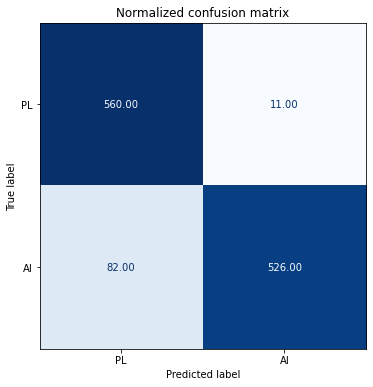

(1179,)
(1179,)


In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["PL", "AI"])
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels=[0,1])
print(y_true.shape)
print(y_preds.shape)

In [24]:
# # upload model to huggingface for storage
# # replace danielhou13 with personal user
# model.push_to_hub("danielhou13/longformer-finetuned_papers")